# Atomap tutorial: finding and analysing sublattices

For more details see the open access article:  
**Atomap: a new software tool for the automated analysis of atomic resolution images using two-dimensional Gaussian fitting**. https://dx.doi.org/10.1186/s40679-017-0042-5

or check the **web site** of the atomap: https://atomap.org/

The code was tested against following packages:

Python = 3.10.8

hyperspy = 1.7.3

scikit-learn = 1.1.3

## 1-  Importing the necessary libraries

In [1]:
%matplotlib notebook
import hyperspy.api as hs
from atomap.tools import remove_atoms_from_image_using_2d_gaussian
from atomap.tools import rotate_points_around_signal_centre
import atomap.api as am
import temul.api as tml
from scipy.ndimage import rotate
import numpy as np
import matplotlib.pyplot as plt
import os

## 2- Loading data

In [10]:
#The path of current directory. 
path=os.getcwd()+"/images"

# Choose only dm format files and png (jpeg is possible too)
dm_files=[file for file in os.listdir(path) if file.endswith((".dm3",".dm4", ".png"))]
dm_files

['BTO_crystal_1.dm4',
 'BTO_crystal_2.dm4',
 'BTO_crystal_3.dm4',
 'four regions_1.png',
 'single domain left image.png',
 'two_pol_up_down.png']

#### 2-1 Creating directories

<IPython.core.display.Javascript object>


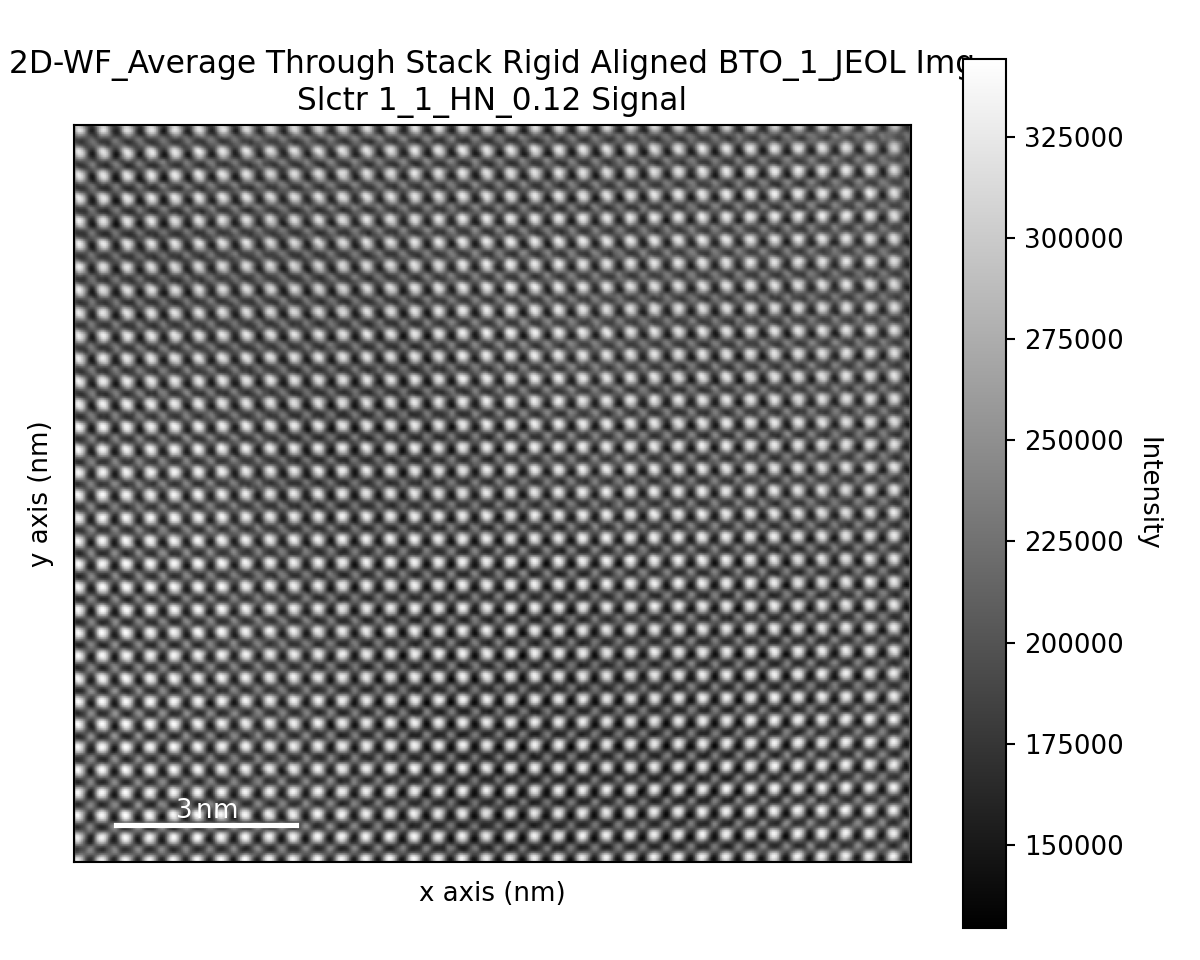

In [19]:
# create a directory to save your results inside a directory where the images are saved. I call it results.
os.makedirs(path +"/"+"results", exist_ok=True )

#Define a varibale which save the name of the image you load and will be used to svae next files 
file_name=dm_files[0]
s_original=hs.load(path +"/"+file_name)
s_original.plot()

#### 2-2 Image processing

<IPython.core.display.Javascript object>


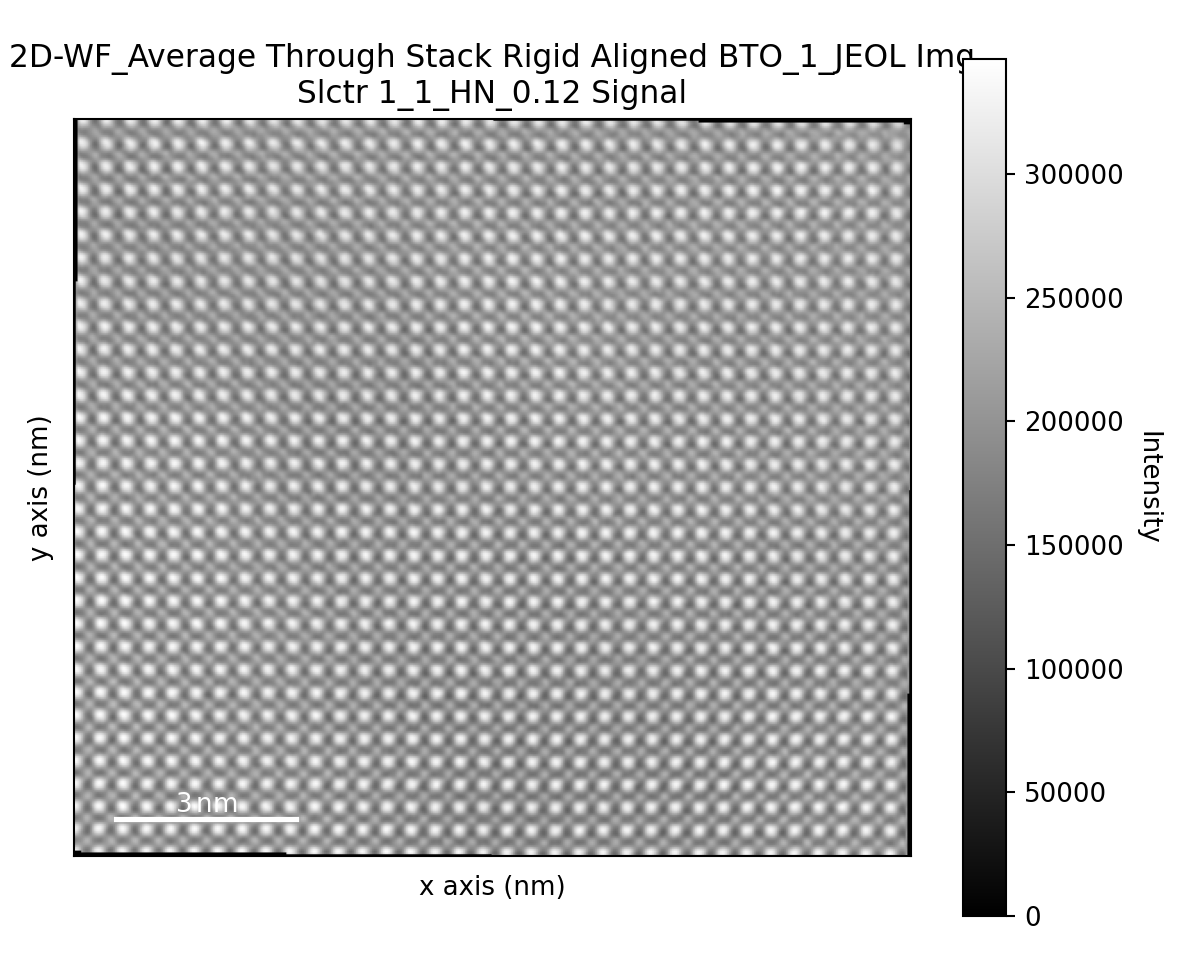

In [20]:
# I think it is easier to work on images where the atomic planes are parallel to the x or y axes of the image

#If necessary, you can rotate your image
rotation = -0.5
s_original.map(rotate, angle=rotation, reshape=False,output_dtype="unit8")

s_original.plot()

<IPython.core.display.Javascript object>


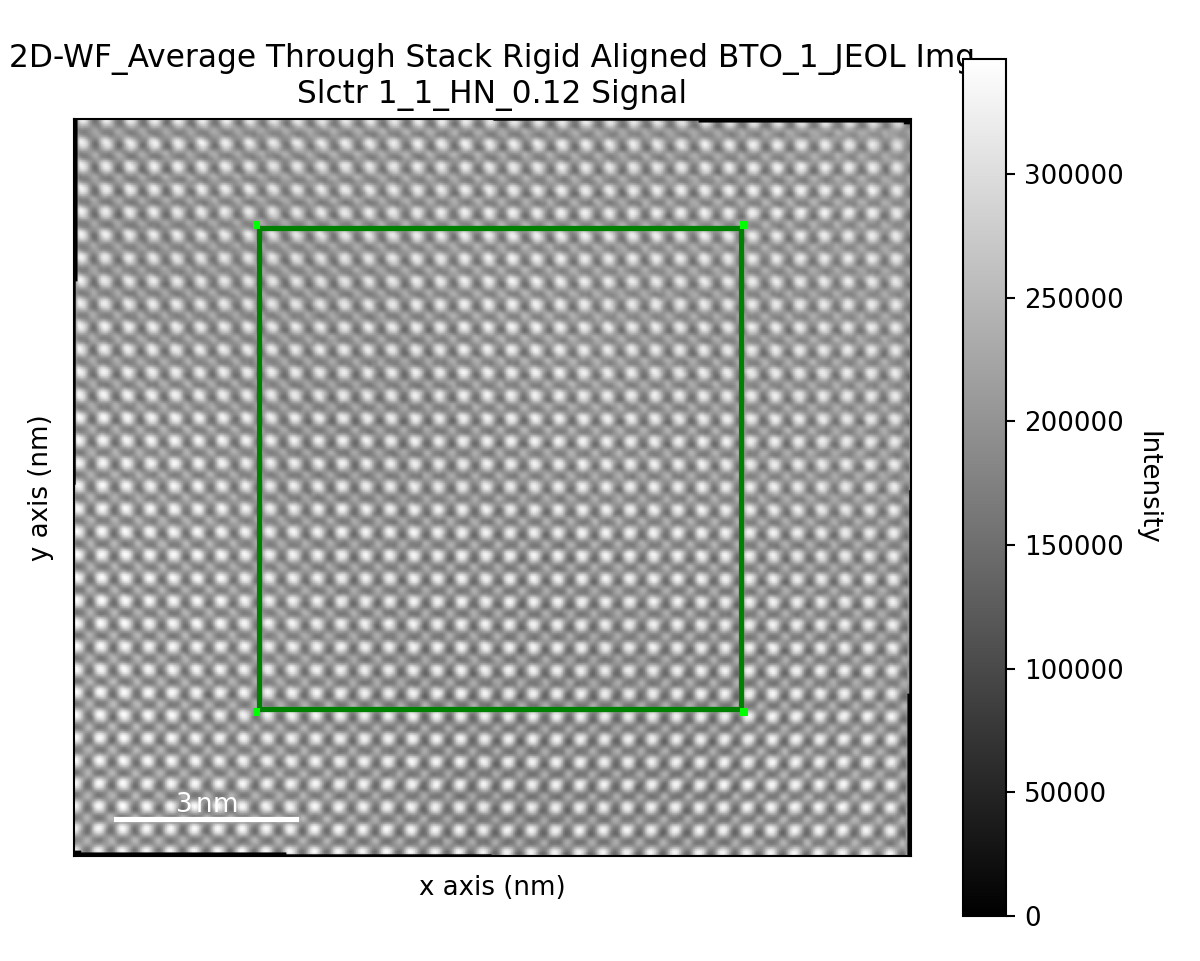

In [69]:
# I usually crop the best part of the image, where less defects or deviation from zone axis presents.
roi = hs.roi.RectangularROI(left=2, right=10, top=2, bottom=10)
s_original.plot()

#For the new image, I use the name of s instead of s_original
s = roi.interactive(s_original)

# Now I will remove the format of the image in the file_name
file_name=file_name.rsplit('.', maxsplit=1)[0]

#save the cropped image under the name: "file_name cropped"
name = f"{file_name} cropped"


In [70]:
#Save the cropped image in png format or in hyperspy format. For the later, please uncomment the line below.

#s.save(path +"/"+"results"+"/"+f"{name}")
plt.savefig(path + f"/results/{name}.png")

## 3- Finding the first sub-lattice

The first sublattice in BaTiO3 or any ABO3 structure is the element which is brighter in HAADF image. Ba is heavier than Ti, so it appears as brighter than Ti ions. Therefore, Ba is the first sublattice. 

I will show some examples of what parameters are very important for tuning to find better match for the atoms of the first sublattice.

#### 3-1 Parameter tunning

In this example, the seperation is low = 2, so the algorithm finds more atoms than what it should find

  0%|          | 0/4 [00:00<?, ?it/s]

[########################################] | 100% Completed | 113.97 ms


  0%|          | 0/30 [00:00<?, ?it/s]

Center of mass:   0%|          | 0/822 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/822 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


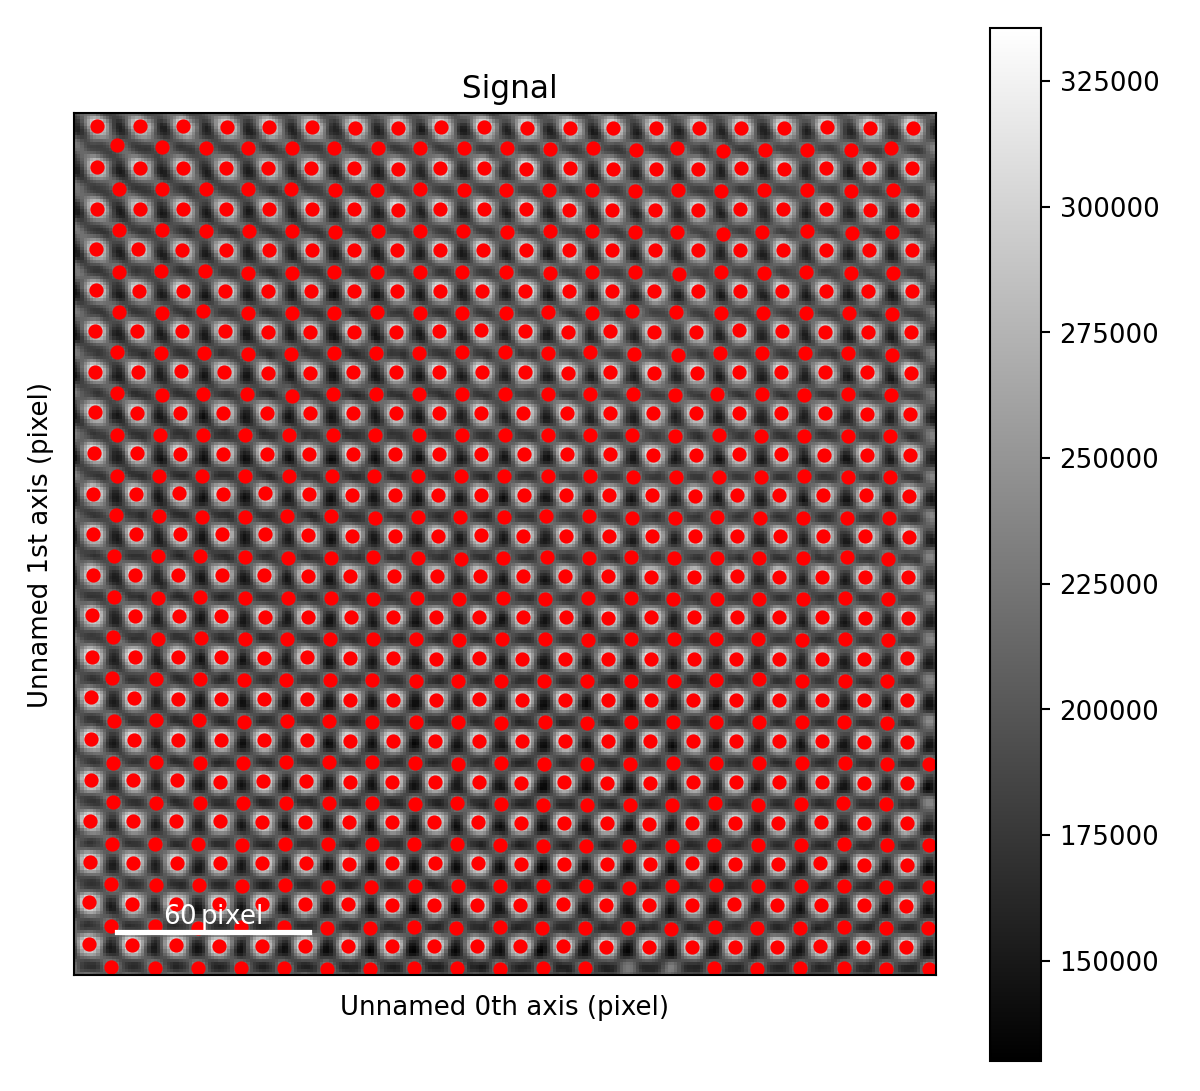

In [71]:
#Seperation range is important, and in my images, it can start from 10 or even 15.
s_peaks = am.get_feature_separation(s, separation_range=(15, 19), pca=True)
atom_positions = am.get_atom_positions(s, separation=2)

#The sublattice is the name of the main sublattice, e.g. Ba in BaTiO3
sublatticeBa = am.Sublattice(atom_position_list=atom_positions, image=s.data)

sublatticeBa.find_nearest_neighbors()

# percent_to_nn parameter can be adjusted to find the optimum positions for the atoms
sublatticeBa.refine_atom_positions_using_center_of_mass(percent_to_nn=0.25)

# This function requires longer time than previous functions to finish its refinement
sublatticeBa.refine_atom_positions_using_2d_gaussian()
sublatticeBa.plot()

  0%|          | 0/4 [00:00<?, ?it/s]

[########################################] | 100% Completed | 114.65 ms


  0%|          | 0/30 [00:00<?, ?it/s]

Center of mass:   0%|          | 0/397 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/397 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


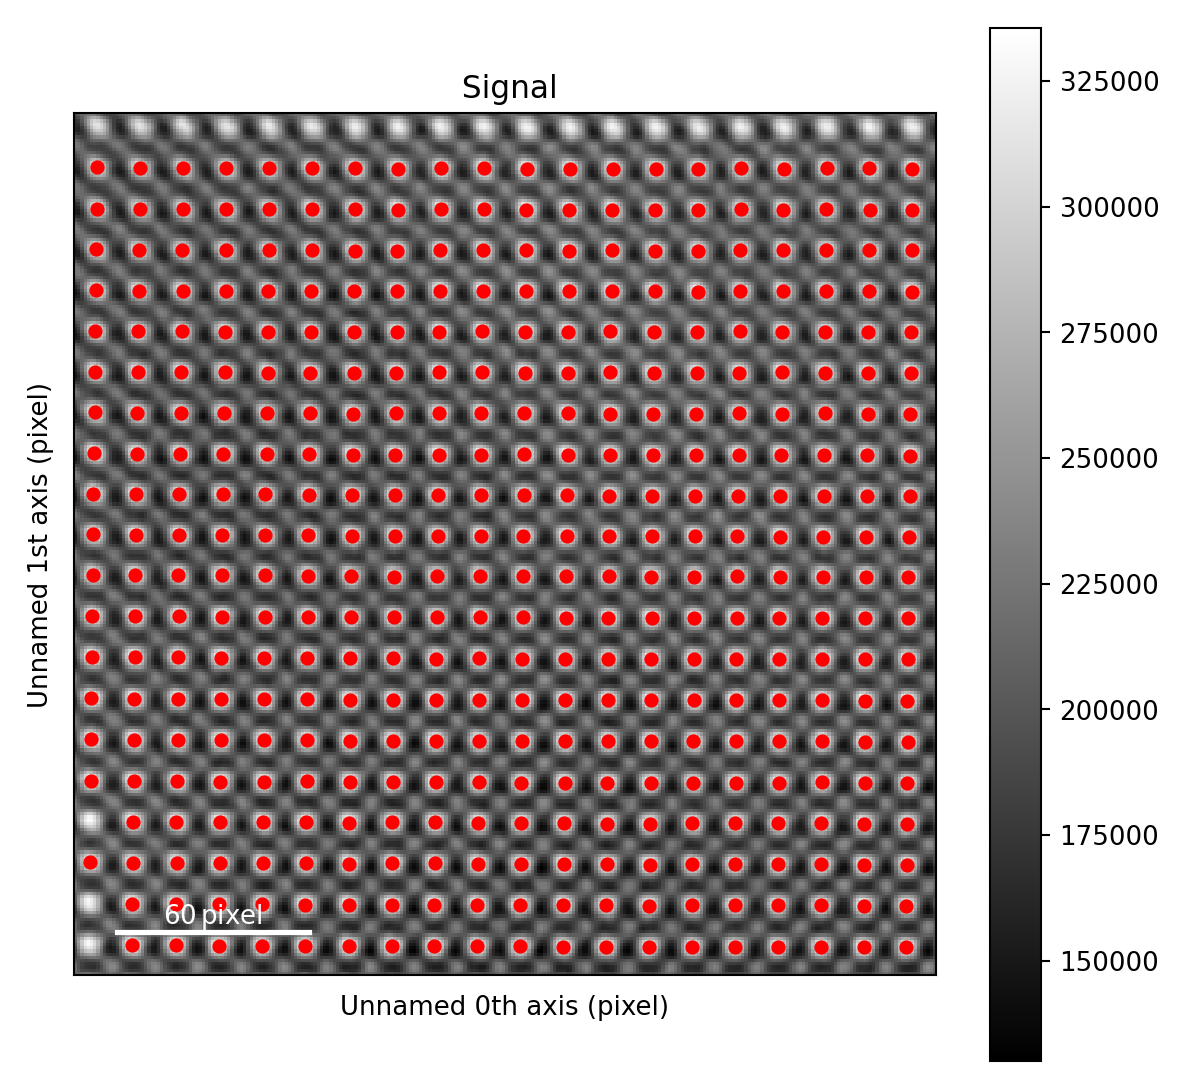

In [72]:
#Seperation range is important, and in my images, it can start from 10 or even 15.
s_peaks = am.get_feature_separation(s, separation_range=(15, 19), pca=True)
atom_positions = am.get_atom_positions(s, separation=5)

sublatticeBa = am.Sublattice(atom_position_list=atom_positions, image=s.data)

sublatticeBa.find_nearest_neighbors()

# percent_to_nn parameter can be adjusted to find the optimum positions for the atoms
sublatticeBa.refine_atom_positions_using_center_of_mass(percent_to_nn=0.25)

# This function requires longer time than previous functions to finish its refinement
sublatticeBa.refine_atom_positions_using_2d_gaussian()
sublatticeBa.plot()

#### 3-2 Constructing zone axis

[(-0.11, 12.82), (13.45, 0.03), (13.35, 12.86), (13.56, -12.79), (13.23, 25.67), (-13.68, 25.6)]
The zone axes for the second sublattice is (13.32, 12.84)


Subtracting atoms:   0%|          | 0/397 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


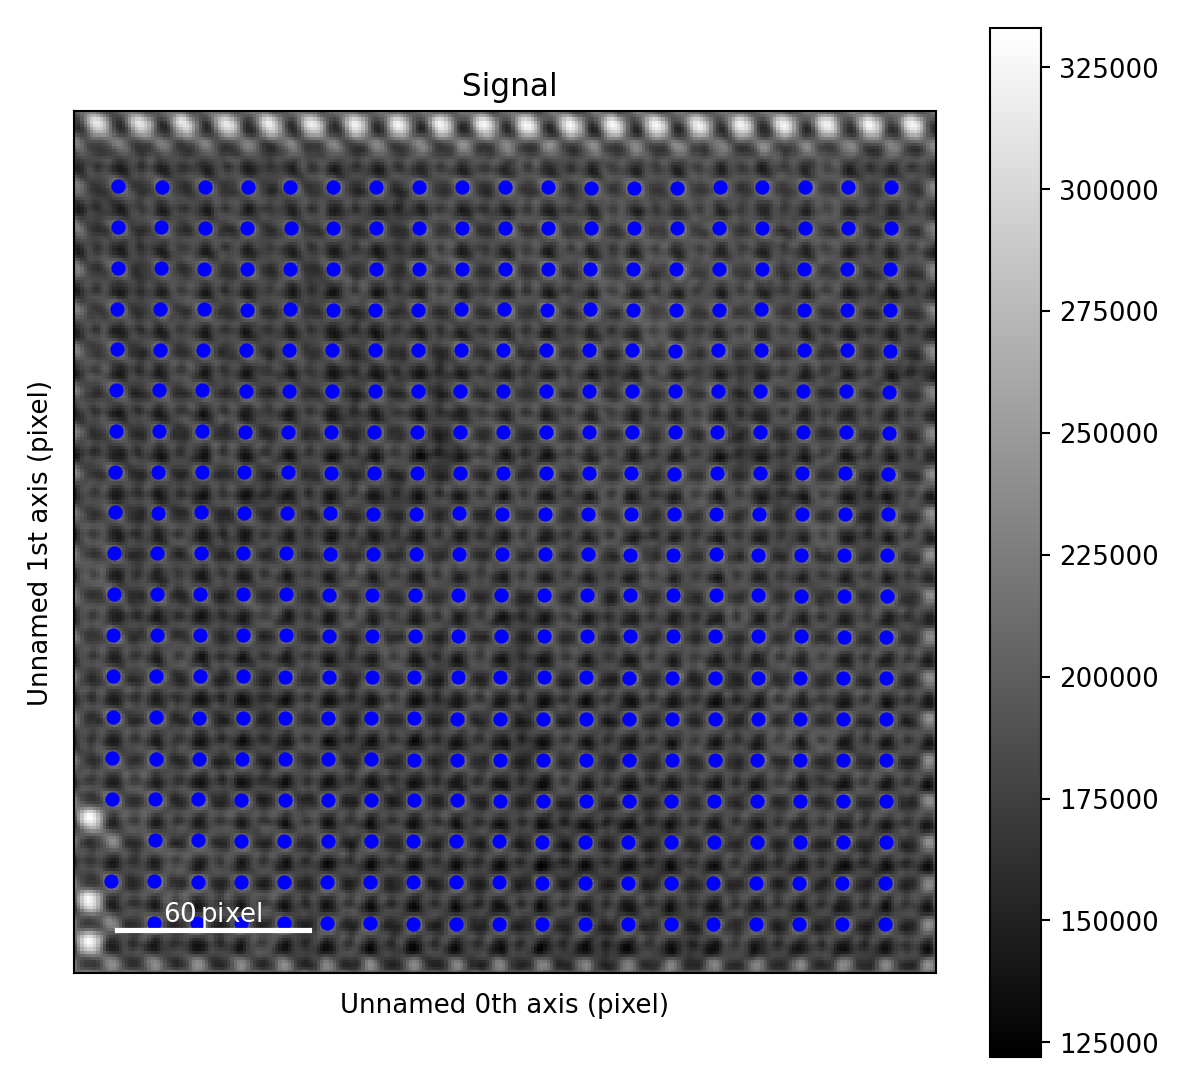

In [73]:
#Constructing zone axes based on sublattice A (Ba in our case):
sublatticeBa.construct_zone_axes()

#Let's print the planes that was found for the Ba lattice.
print(sublatticeBa.zones_axis_average_distances)

#Choosing a zone axis which is 45 degrees rotated with respect to the x or y axis
zone_axes = sublatticeBa.zones_axis_average_distances[2]
print(f"The zone axes for the second sublattice is {zone_axis}")

# The algorithm finds the atoms with respect to the given zone axes

atom_positions_Ti = sublatticeBa.find_missing_atoms_from_zone_vector(zone_axes)

#Secondly, we "subtract" the intensity of the sublattice atoms from the fantasite image
image_atoms_subtracted = remove_atoms_from_image_using_2d_gaussian(sublatticeBa.image, sublatticeBa)

# Which we use to make the second sublattice:
sublatticeTi = am.Sublattice(atom_positions_Ti, image_atoms_subtracted, color='blue',fix_negative_values=True)
sublatticeTi.plot()

#### 3-3 Finding the positions for second sublattice (Ti sublattice).

Center of mass:   0%|          | 0/359 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


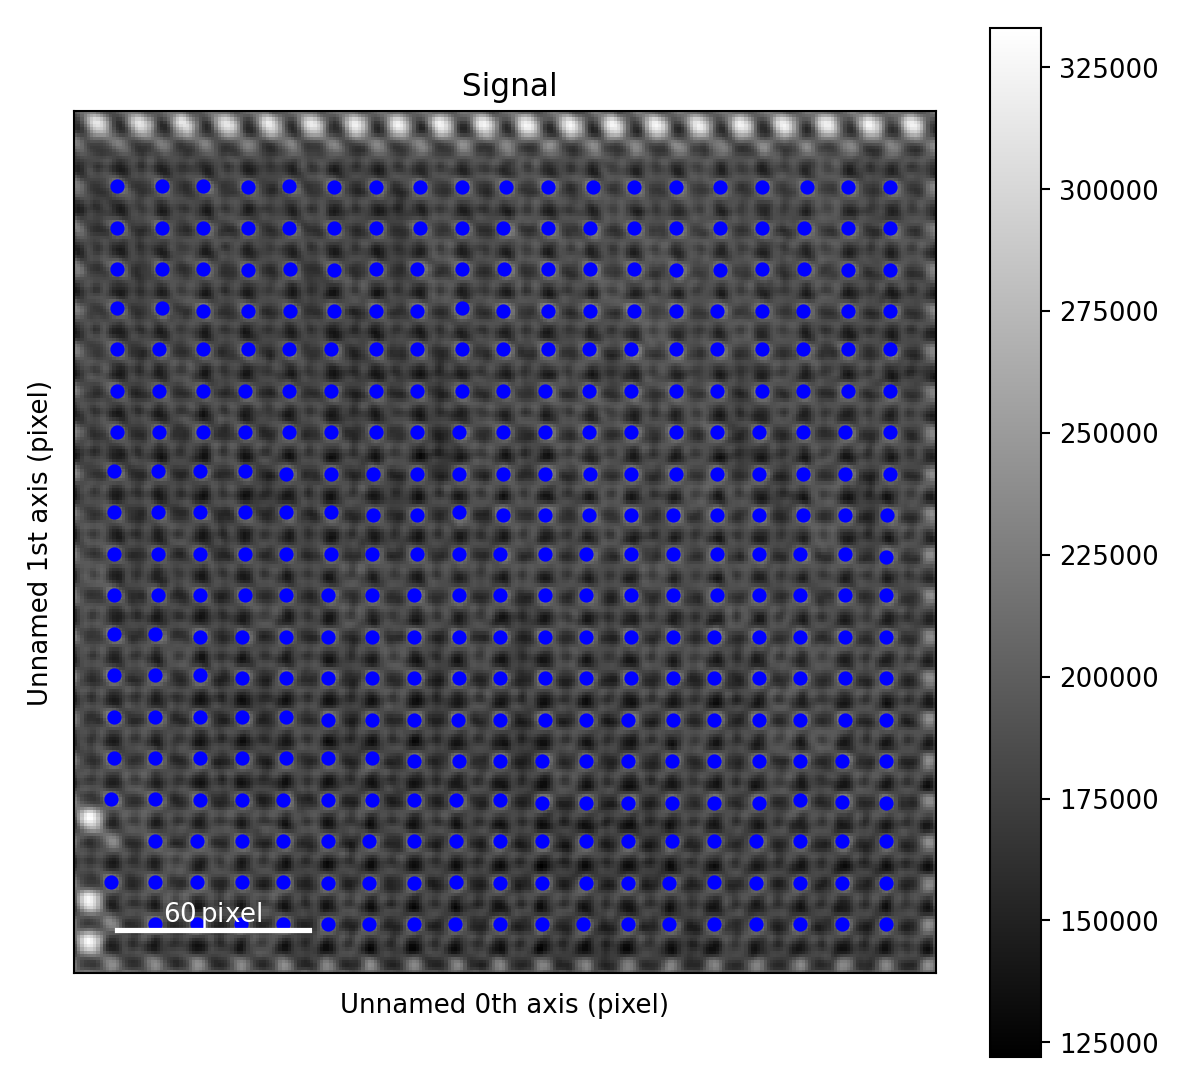

In [74]:
sublatticeTi.construct_zone_axes()

# The parameters in Refine_atom_positions should be adjusted according to image quality e.g. percent_to_nn=0.23 or
# percent_to_nn=0.21. The default value for percent_to_nn is 0.25. So start with 0.25 and if not happy, change it.

sublatticeTi.refine_atom_positions_using_center_of_mass(percent_to_nn=0.24)

sublatticeTi.plot()

Gaussian fitting:   0%|          | 0/359 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


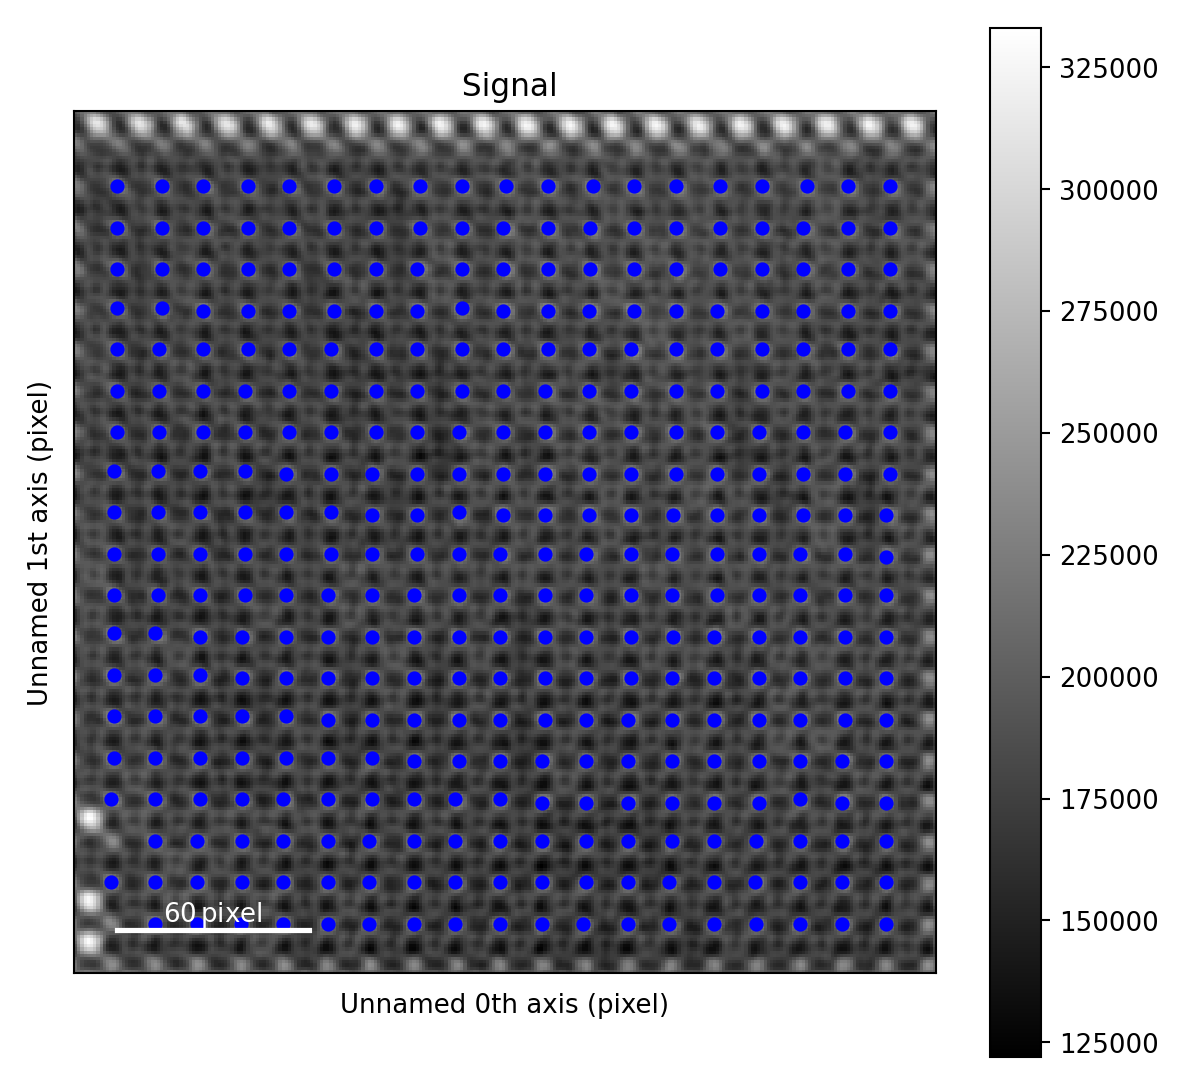

In [75]:
#This is a further refinement and takes a bit of time. Usually I use it when there is a need for better refinement.
#Only in the case of images with defects, I had to paly with parameters of the function: percent_to_nn or mask_radius

sublatticeTi.refine_atom_positions_using_2d_gaussian(mask_radius=1)
sublatticeTi.plot()

#### 3-4 Merging all sublattices

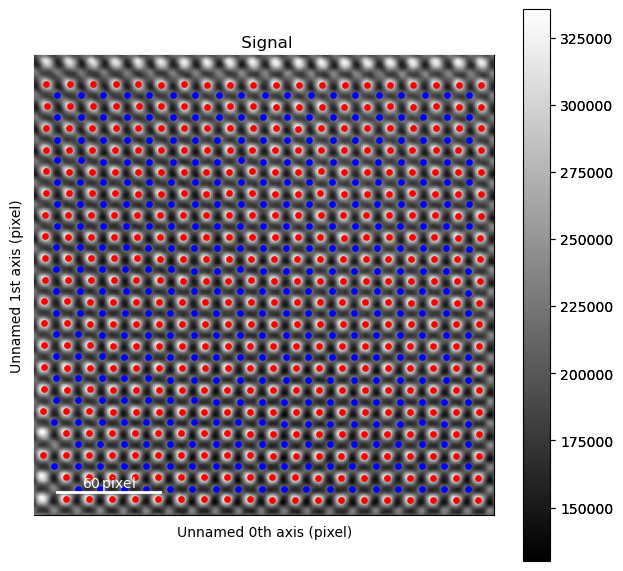

In [82]:
# Now we can combine both sublattice of Ba and Ti,and plot the final matching for both Ba and Ti positions.

atom_lattice = am.Atom_Lattice(image=s.data, name=path + f"/results/{name} atom_lattice.png", 
                               sublattice_list=[sublatticeBa, sublatticeTi])

atom_lattice.plot(markersize=15)

#We can save the atomic positions which were found by the process so far in different formats like txt, ...
atom_lattice.save(filename=path+f"/results/{name} atom_lattice.hdf5",overwrite=True)  
np.savetxt(path+f"/results/{name} atom_lattice.csv", (sublatticeBa.x_position,
                            sublatticeBa.y_position,
                            sublatticeBa.sigma_x,
                            sublatticeBa.sigma_y,
                            sublatticeBa.ellipticity),
                            delimiter=',')

## 4- Using TEMUL to calculate polarization

In [83]:
%matplotlib inline

In [85]:
# The zone axes of ineterst from Ba lattice will be used to extract polarizationinformation from Ti sublattice
z1, z2= sublatticeBa.zones_axis_average_distances[0:2]

# The polarization from Ti sublattice is calculated with respect to z1 and z2 zone axes
s_p = sublatticeBa.get_polarization_from_second_sublattice(z1, z2, sublatticeTi, color='blue')

vector_list_s_p = s_p.metadata.vector_list

# Now we extract x and y positions of the atoms and the displacmeent of the Ti ions as u and v.
x, y = [i[0] for i in vector_list_s_p], [i[1] for i in vector_list_s_p]
u, v = [i[2] for i in vector_list_s_p], [i[3] for i in vector_list_s_p]

#### 4-1 Plotting the amplitude and angle of the Ti displacement for each atom

There are different ways to illustrate the results for different purposes. The best is that to check them in the web site of the TEMUL Toolkit.

In [86]:
# We can access the scale and units of the acquired images as follows:
sampling=s.axes_manager[-1].scale
unit=s.axes_manager[-1].units
sampling, unit

(0.029659930616617203, 'nm')

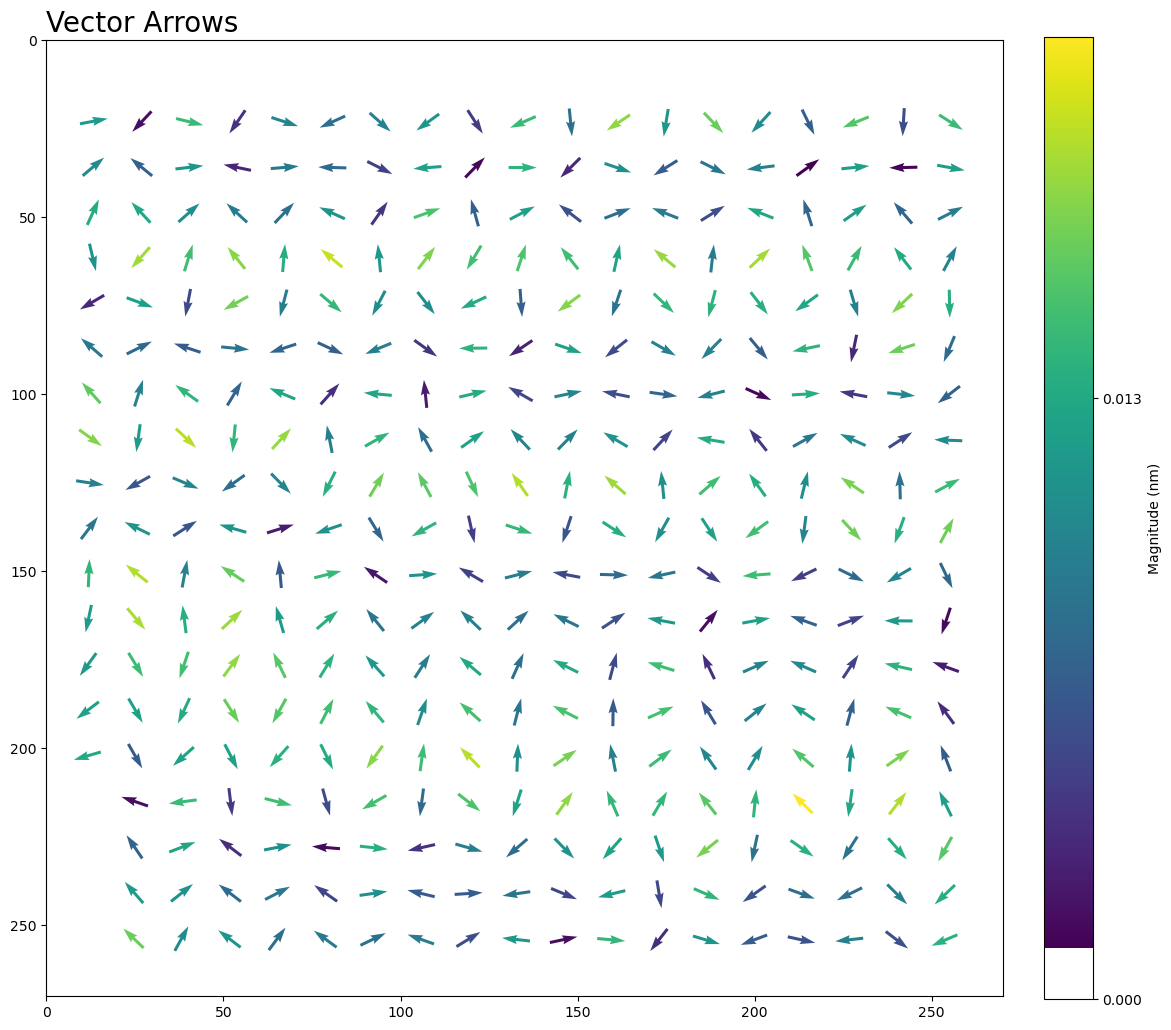

In [88]:
#Vector magnitude plot with colormap viridis:

tml.plot_polarisation_vectors(x, y, u, v, 
                            image=s.data, 
                            units=unit, sampling=sampling,
                            unit_vector=True, save=None, 
                            plot_style="colormap", monitor_dpi=20, 
                            vector_rep="magnitude", title="Vector Arrows",
                            overlay=False, cmap="viridis", 
                            scalebar=False, ticks=[0.0,0.013],
                            no_axis_info=False
                             )
plt.savefig(path+f"/results/{name}+vector magnitude")

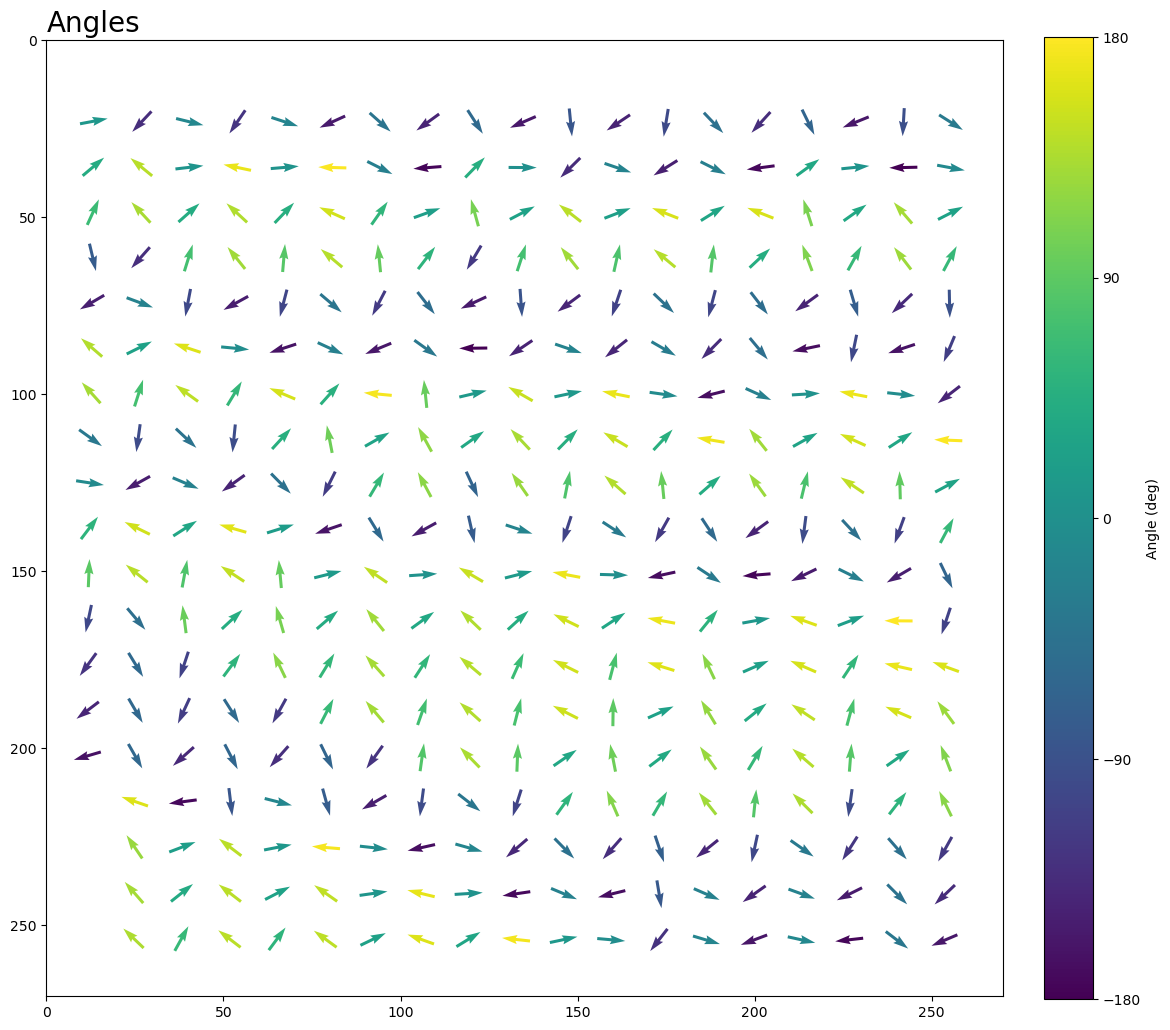

In [89]:
#angle plot with colormap viridis:

tml.plot_polarisation_vectors(x, y, u, v, 
                              image=s.data,
                              units=unit, sampling=sampling,
                              unit_vector=True, save=None, 
                              plot_style="colormap", monitor_dpi=20, 
                              title="Angles", vector_rep="angle",
                              overlay=False, cmap="viridis",  scalebar=False,
                              degrees=True, pivot='middle',
                              ticks=[180, 90, 0, -90, -180],
                              no_axis_info=False
                             )
plt.savefig(path+f"/results/{name}+angle")

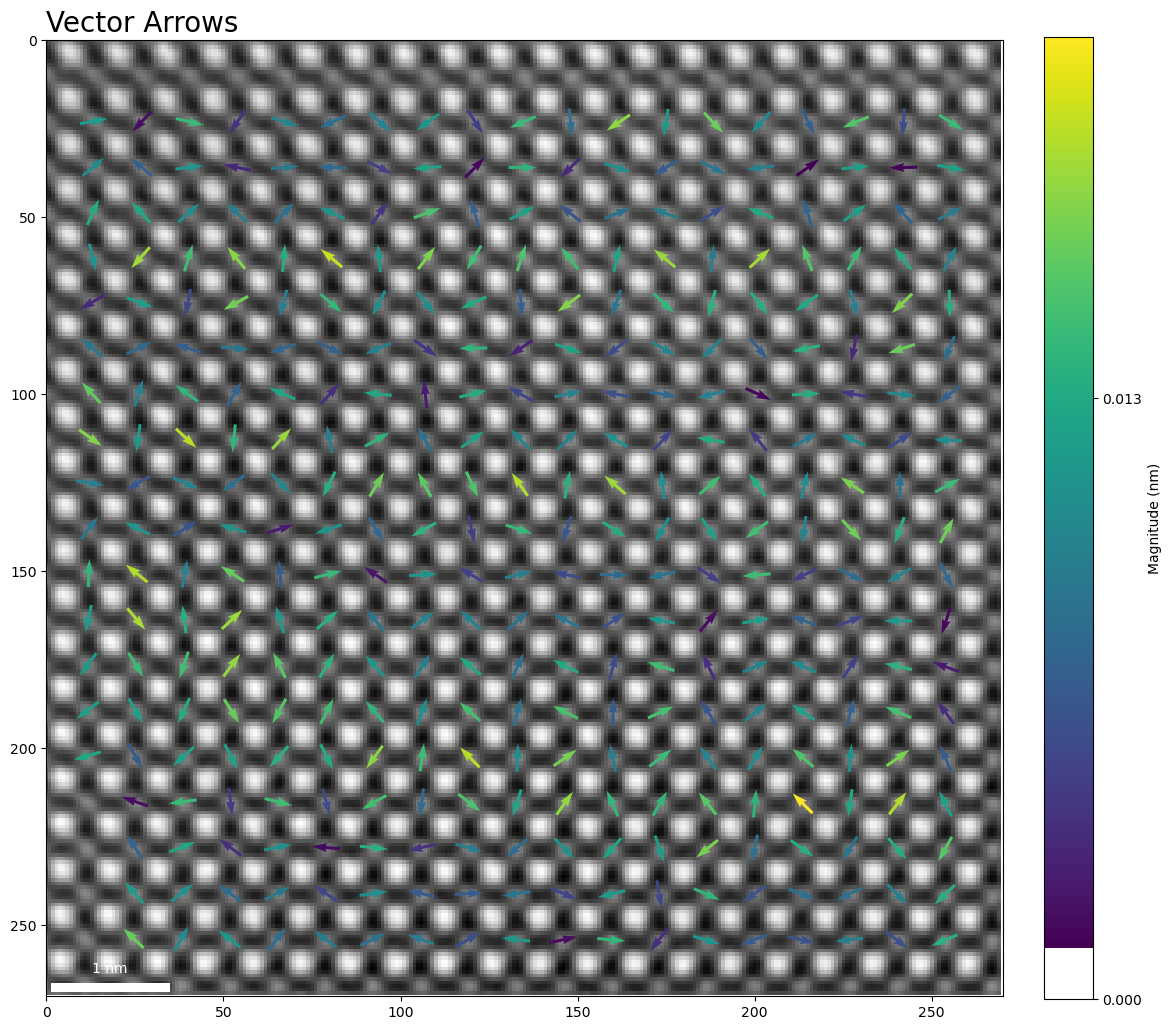

In [95]:
#Vector magnitude plot with colormap viridis overlaid on the image: 
tml.plot_polarisation_vectors(x, y, u, v, 
                             image=s.data,
                             sampling=sampling, units=unit,
                             unit_vector=True, save=None, 
                             plot_style="colormap", monitor_dpi=20,
                             vector_rep="magnitude", title="Vector Arrows",
                             overlay=True, cmap="viridis", scalebar=True,
                             ticks=[0.0, 0.013], 
                             no_axis_info=False
                              )

plt.savefig(path+f"/results/{name}+overlaid vector magnitude")

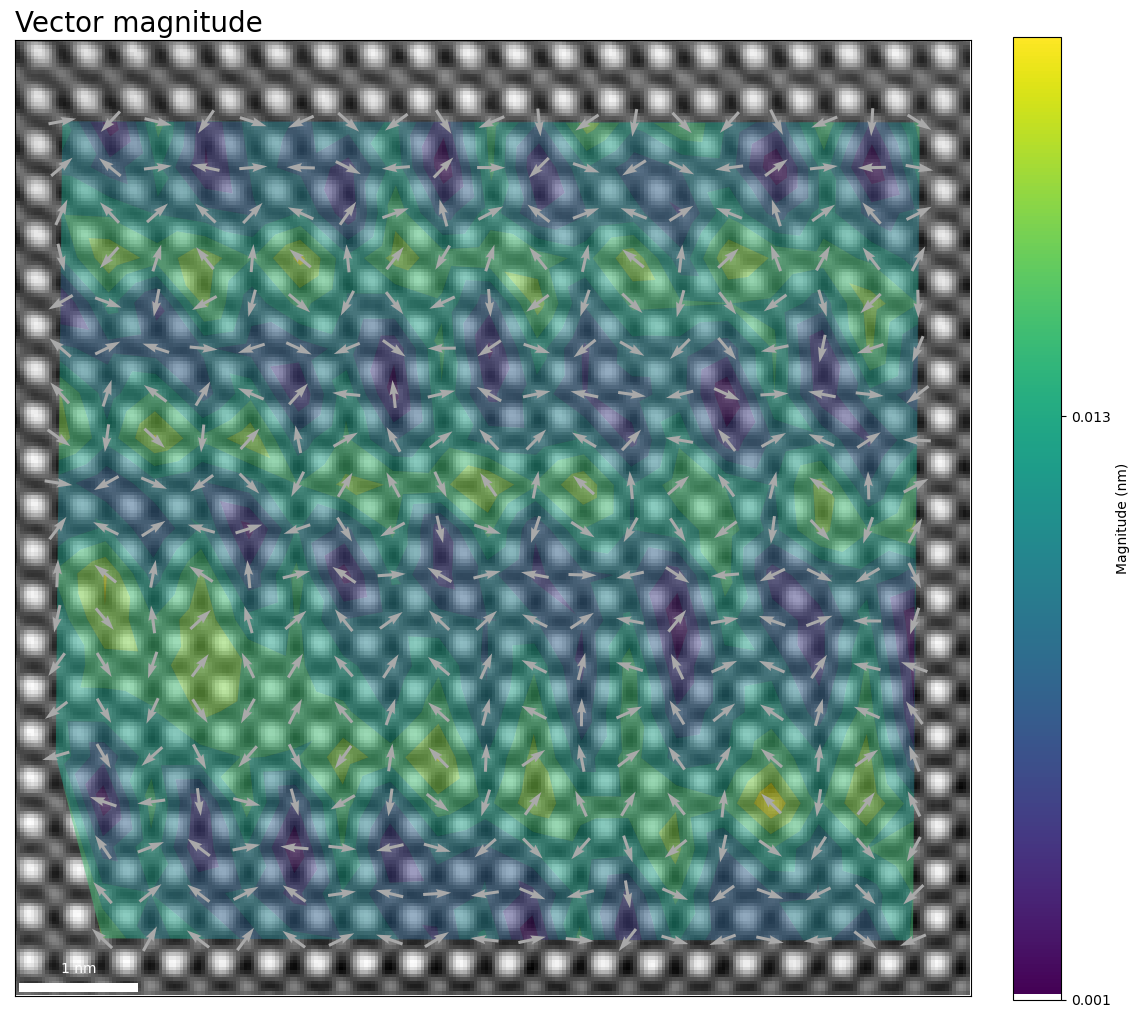

In [96]:
#Change the vectors to unit vectors on a Matplotlib tricontourf map:

tml.plot_polarisation_vectors(x, y, u, v,                                                           
                             image=s.data,
                             sampling=sampling, units=unit,
                             unit_vector=True, save=None,
                             plot_style="contour", monitor_dpi=20,
                             vector_rep="magnitude", title="Vector magnitude",
                             overlay=True, cmap="viridis", scalebar=True,
                             ticks=[0.001, 0.013], color="darkgray", alpha=0.5, 
                             levels=9, antialiased=True
                             )
                              
plt.savefig(path+f"/results/{name}+overlaid vector magnitude contour")                       

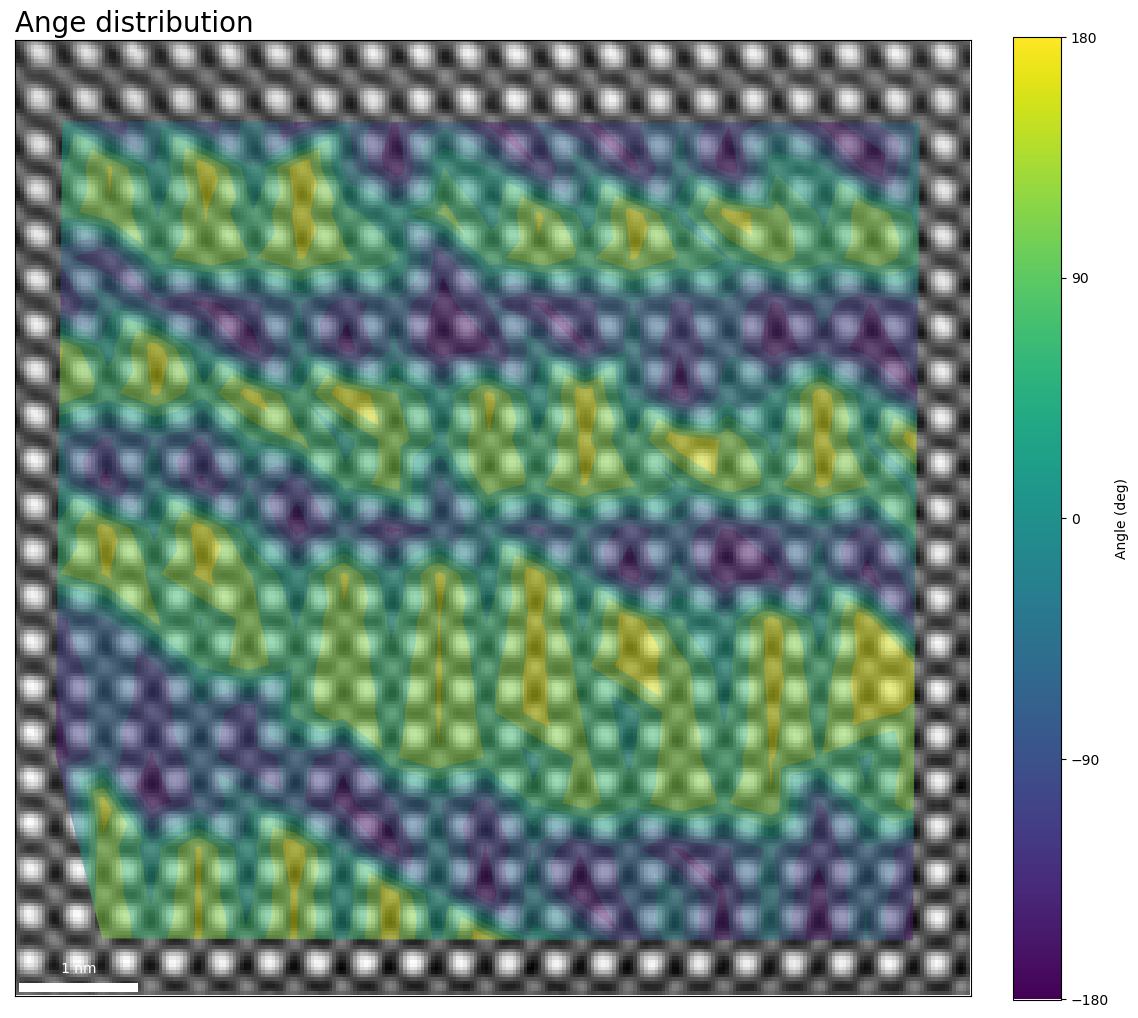

In [97]:
# Plot a partly transparent angle tricontourf map with specified colorbar ticks and vector arrows:cet_colorwheel

tml.plot_polarisation_vectors(x, y, u, v, 
                              image=s.data,
                              sampling=sampling, units=unit,
                              unit_vector=True, save=None, 
                              plot_style="contour", monitor_dpi=20,
                              vector_rep="angle", title="Ange distribution",
                              overlay=True, cmap="viridis", scalebar=True, 
                              color="darkgray",alpha=0.5, levels=9,
                              antialiased=True, degrees=True, pivot='middle',
                              ticks=[180, 90, 0, -90, -180], 
                              remove_vectors=True
                             )
                                                           
plt.savefig(path+f"/results/{name}+overlaid  angle contour")                                    

## 5- PCA (principal component analysis) analysis

In [123]:
import pandas as pd
from sklearn.decomposition import KernelPCA, TruncatedSVD, PCA

The follwoing functions will apply PCA analysis on u and v vvalues, the displacement of the Ti ions. The objective is to reduce noise in the data. This process assuems that we are confident with x and y values. Means that the process of the finding atoms for both Ba and Ti ions were sucessful. Although one can also apply PCA analysis on x and y values too, this might change the scaling of the data when the polarization map is overlaid on the real image.  

In [209]:
# We can choose one of the follwoing function to use for noise reduction. 
# It is a good practice to tune the hyperparameters according to the image quality
# Since the data of u and v are in small range, I do not do any prior standardization common in PCA analysis.

def pca_svd(x,y,u,v):
    """
    This function applies PCA or PCA randomized SVD on u and v and returns new u and v, u1 and v1.
    u and v: displacements of the Ti ions.
    """
    
    #It is easier to navigate the data when they are in tabular form. 
    #You can use vector_s.head() to look at few first lines of the data
    
    u_v = list(zip(u,v))
    vector_s = pd.DataFrame(u_v, columns=["sigma_x", "sigma_y"])
    
    #you can choose svd_solver = "auto" or "randomized". 
    pca = PCA(n_components = 1,
              random_state = 42, 
              svd_solver = "auto")
    # Apply fit and transform on pca anaylsed data
    vector_s_pca= pca.fit_transform(vector_s)
    
    # Use inverse_transform to go back to the original space
    vector_s_filtered =pca.inverse_transform(vector_s_pca)
    print("number of components for PCA: ",pca.n_components_)

    x1, y1=  x, y
    u1, v1 = [i[0] for i in vector_s_filtered], [i[1] for i in vector_s_filtered]
    return x1, y1, u1, v1


def svd_truncated(x,y,u,v):
    """ 
    This fucntion applies truncated SVD on u and v values.
    u and v: displacements of the Ti ions.
    """
    
    #new_list=list(zip(x,y,u,v))
    #vector_s=pd.DataFrame(new_list, columns=["x", "y","sigma_x", "sigma_y"])
    
    u_v = list(zip(u,v))
    vector_s = pd.DataFrame(u_v, columns=["sigma_x", "sigma_y"])
   
    svd = TruncatedSVD(n_components = 2, 
                       n_iter = 6, 
                       random_state = 42)
    
    vector_s_svd= svd.fit_transform(vector_s)
    
    # Use inverse_transform to go back to the original space
    vector_s_filtered =svd.inverse_transform(vector_s_svd)

    #x1, y1 = [i[0] for i in vector_s_filtered], [i[1] for i in vector_s_filtered]
    x1, y1 = x, y
    u1, v1 = [i[0] for i in vector_s_filtered], [i[1] for i in vector_s_filtered]
    return x1, y1, u1, v1


def pca_kernel(x,y,u,v):
    """
    This function applies kernel PCA on u, v and returns new values. It requires more hyperparametr tunning.
    u and v: displacements of the Ti ions.
    """
    
    u_v=list(zip(u,v))
    vector_s=pd.DataFrame(u_v, columns=["sigma_x", "sigma_y"])
    
    kpca = KernelPCA(n_components = 9, 
                     kernel = "rbf", 
                     gamma = 1e-2, 
                     fit_inverse_transform = True, 
                     alpha = 0.001, 
                     random_state = 42)
    
    vector_s_kpca= kpca.fit_transform(vector_s)
    
    # Use inverse_transform to go back to the original space
    vector_s_filtered =kpca.inverse_transform(vector_s_kpca)
    print("number of components for kernel PCA: ", kpca.n_components)
   
    x1, y1 = x, y
    u1, v1 = [i[0] for i in vector_s_filtered], [i[1] for i in vector_s_filtered]
    return x1, y1, u1, v1


def no_process(x,y,u,v):
    """ 
    In case, we do not want to apply any denoising, this fucntion resturns the original values of 
    x, y, u, and v with new names to be used for the later processes.
    u and v: displacements of the Ti ions.
    """
    x1, y1= x, y
    u1, v1= u, v
    return x1, y1, u1, v1


In [214]:
# Apply one of the above functions on data and tune hyperparameter if needed

x1, y1, u1, v1 = pca_svd(x, y, u, v)
#x1, y1, u1, v1 = no_process(x, y, u, v)

# Create a pandas dataframe to evlauate the values of e.g. u and u1 and their difference after applying denoising

pd.DataFrame({"u":u, "u1":u1, "u-u1":np.subtract(u,u1)}).head(7)

number of components for PCA:  1


u        u1      u-u1
0 -0.054541 -0.055781  0.001240
1 -0.261559 -0.245887 -0.015673
2 -0.250630 -0.277219  0.026589
3 -0.463134 -0.452034 -0.011101
4  0.464898  0.480277 -0.015379
5 -0.218862 -0.216833 -0.002029
6 -0.344174 -0.331738 -0.012436

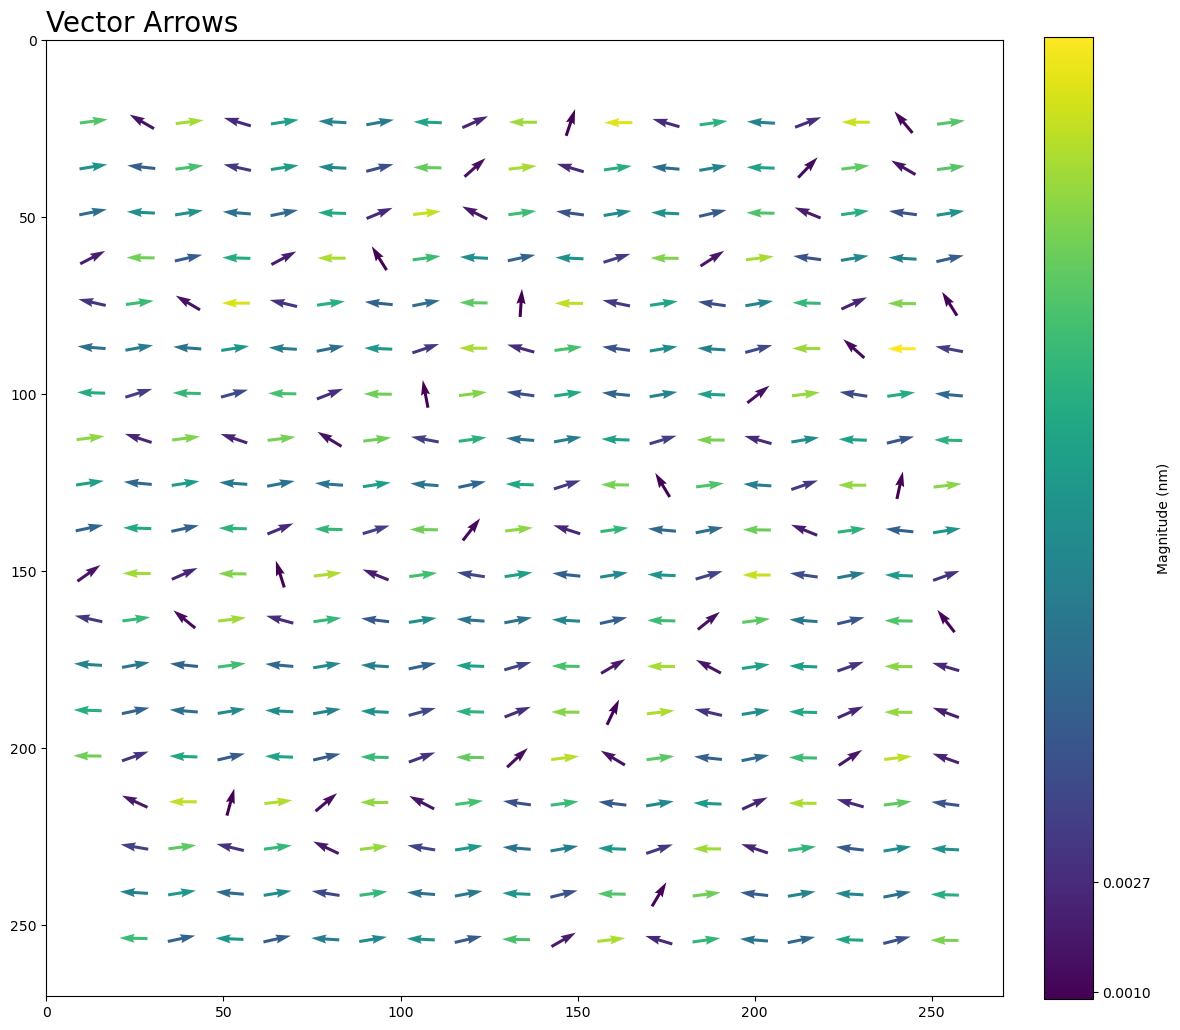

In [215]:
#Vector magnitude plot with colormap viridis:
tml.plot_polarisation_vectors(x1, y1, u1, v1, 
                        image=s.data,units=unit, sampling=sampling,
                          unit_vector=True, save=None, vector_rep="magnitude",
                          plot_style="colormap", monitor_dpi=20,title="Vector Arrows",
                          overlay=False, cmap="viridis",  scalebar=False,  ticks=[0.001,0.0027], no_axis_info=False
                             )
plt.savefig(path+f"/results/{name}+vector magnitude PCA applied")

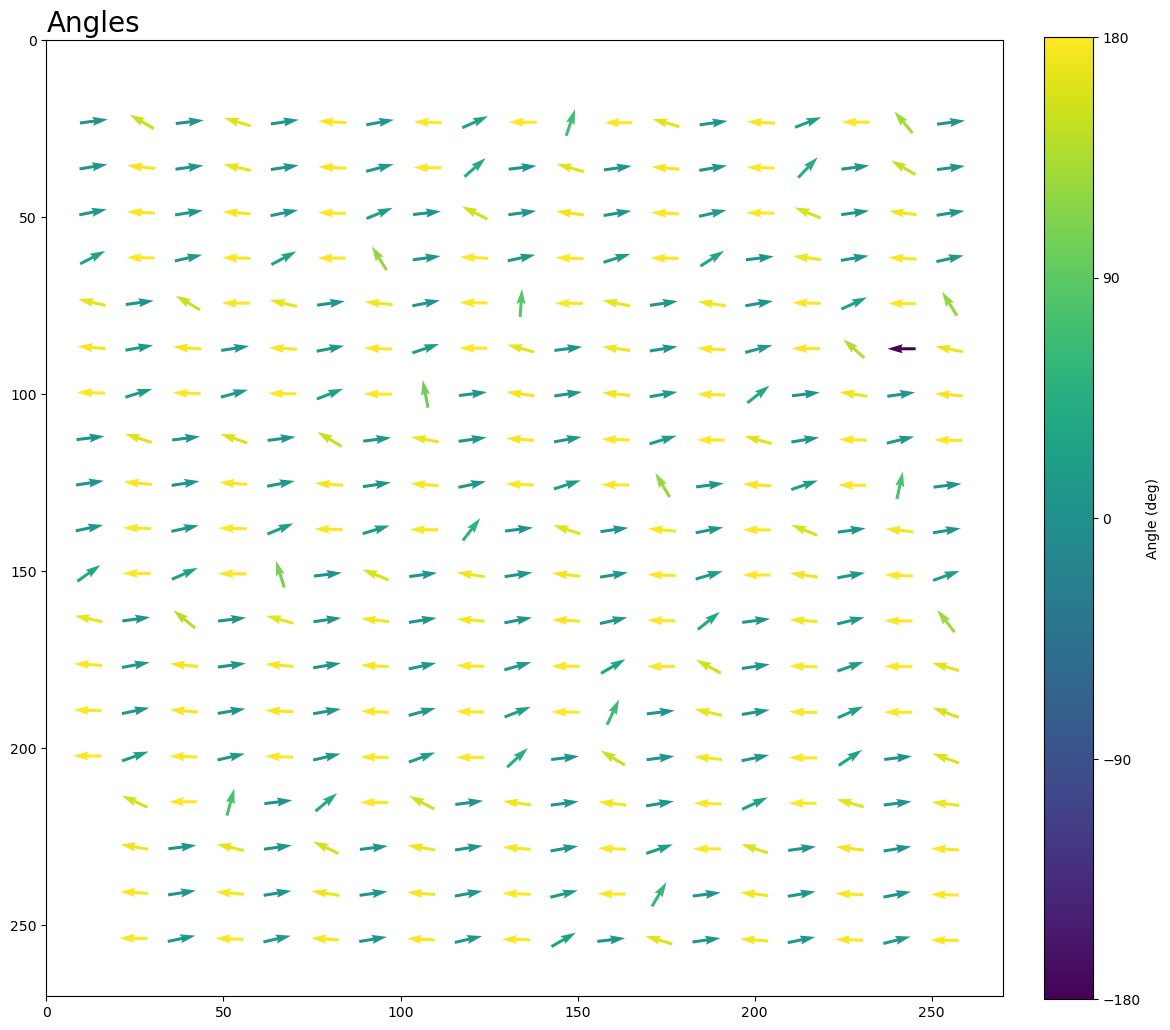

In [216]:
#angle plot with colormap viridis:

tml.plot_polarisation_vectors(x1, y1, u1, v1, 
                        image=s.data,units=unit, sampling=sampling,
                          unit_vector=True, save=None, vector_rep="angle",
                          plot_style="colormap", monitor_dpi=20,title="Angles",
                          overlay=False, cmap="viridis",  scalebar=False, degrees=True, pivot='middle',
                              ticks=[180, 90, 0, -90, -180], no_axis_info=False
                             )
plt.savefig(path+f"/results/{name}+angle PCA applied")

## 6- PCA based image and KMeans Clustering

In [130]:
import pandas as pd
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

This is only a short practice to use unsupervised learning to identify the regions of similar polarization in an image. The algorithm is the combination of PCA analysis for the deniosing and KMeans clustering from scikit-learn. 

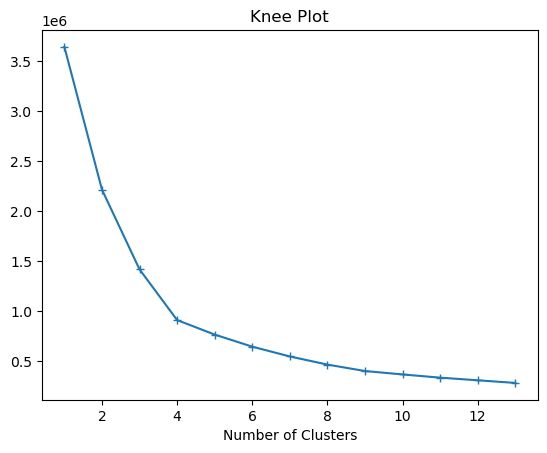

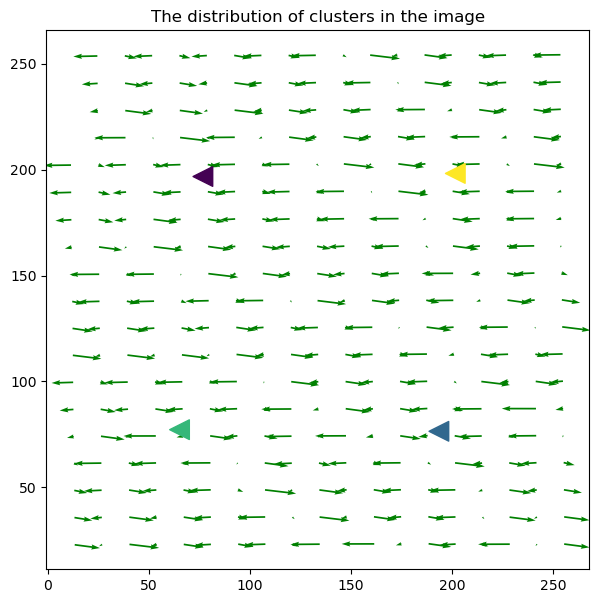

In [230]:
#We can check the number of clusters from KMenas and Plot them
#Create the dataset with x,y,u,,v values from PCA analysis

vector_uv=np.array([x1, y1 , u1, v1]).T

inertia = []
for n in range(1 , 14):
    kmeans_test = KMeans(n_clusters=n,max_iter=10000,random_state=42,n_init=20 )
    kmeans_test.fit(vector_uv)
    inertia.append(kmeans_test.inertia_)
plt.plot(range(1,14), inertia,"+-" )
plt.xlabel("Number of Clusters")
plt.title("Knee Plot");

#Now we implement the final KMeans model. The chosen number of clusters depends on Knee plot.
# The Knee plot shows an abrupt change in the plot which usually indicates the proper number of clusters
n_clusters=4
kmeans = KMeans(n_clusters=n_clusters, 
                max_iter=10000, 
                random_state=42, 
                n_init=10)
kmeans.fit_predict(vector_uv)

#Get the center of each cluster
kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1]

plt.figure(figsize=(7,7))
#plot the polarization, using matplotlib
plt.quiver(vector_uv[:,0], 
           vector_uv[:,1], 
           vector_uv[:,2], 
           vector_uv[:,3], 
           data=vector_uv, 
           color="g" )

#Plot the center of each cluster in polarization map
plt.scatter(kmeans.cluster_centers_[:,0],
            kmeans.cluster_centers_[:,1],
            s=200, 
            c=[i for i in range(n_clusters)], 
            marker="<")

plt.title("The distribution of clusters in the image");